In [1]:
import fastai
from fastai.vision import *

from torchvision import models
from visualization.modules import LayeredModule, get_nested_layers
from visualization.data import *
from visualization.image_proc import *
from visualization.interpret import NetLens

# Todos
* Remove babies (age < 5) from the dataset. They are weird mushes of flesh that are hard to classify
* there are some bugs with labels (aka plot_losses shows females that aren't labeled as such)
* 

In [3]:
path = Path("/home/jupyter/fai-berlin-faces/cropped/")


Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [4]:
verify_images(path, recurse=True)

In [5]:
path

PosixPath('/home/jupyter/fai-berlin-faces/cropped')

In [6]:
sample = [x for x in path.iterdir()][:5]
sample

[PosixPath('/home/jupyter/fai-berlin-faces/cropped/2_1_2_20161219212017166.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/63_0_0_20170111201901467.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/33_1_3_20170104223525079.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/49_1_0_20170104235655316.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/25_1_0_20170103182309849.jpg.chip.jpg')]

## Label Fns 
We should also try multilabel and a loss function that combines age / gender / ethnicity

In [7]:
def get_age(path): return int(path.name.split("_")[0])
[get_age(p) for p in sample]

[2, 63, 33, 49, 25]

In [8]:
def isFemale(path): return bool(int(path.name.split('_')[1]))

def get_gender(path):
   # print(path, "path here")
    return "female" if isFemale(path) else "male"

[isFemale(p) for p in sample], [get_gender(p) for p in sample] #isFemale(sample[1]), get_gender(sample[1])

([True, False, True, True, True],
 ['female', 'male', 'female', 'female', 'female'])

In [9]:
races = ["White", "Black", "Asian", "Indian", "Others"]

def get_race(path):
    return races[int(path.name.split("_")[2])]
[get_race(p) for p in sample]

['Asian', 'White', 'Indian', 'White', 'White']

In [10]:
#seems to bee no file_name issues
for p in path.iterdir():
    try:
        
        get_age(p)
    except: 
        print(p)
         

/home/jupyter/fai-berlin-faces/cropped/models


In [11]:
#! rm "/home/jupyter/fai-berlin-faces/cropped/61_1_20170109142408075.jpg.chip.jpg"
#! rm "/home/jupyter/fai-berlin-faces/cropped/61_3_20170109150557335.jpg.chip.jpg"


## Classify Gender without Augmentation

In [12]:
tfms = []
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_gender) \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [43]:
learner = cnn_learner(data, models.vgg19, metrics=[accuracy])
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.742687,0.495820,0.794885,01:00
1,0.534835,0.444230,0.793350,00:56


In [44]:
learner.unfreeze()

In [45]:
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.770920,0.663463,0.638875,02:22
1,0.684502,0.560508,0.701279,02:17


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


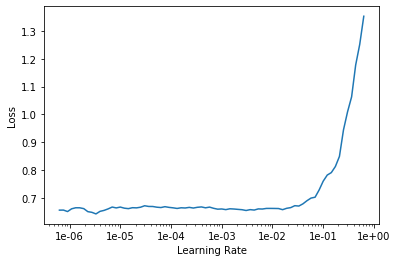

In [46]:
learner.lr_find()
learner.recorder.plot()

1734 misclassified samples over 1955 samples in the validation set.


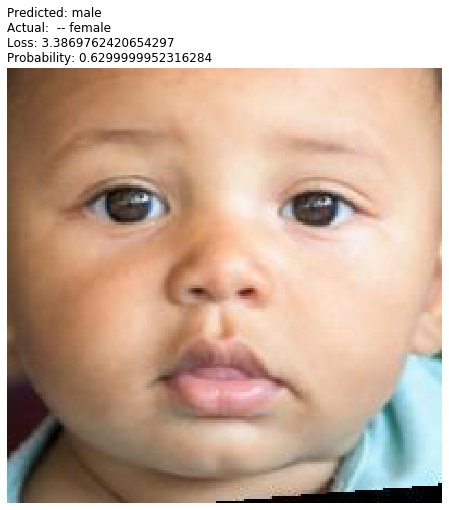

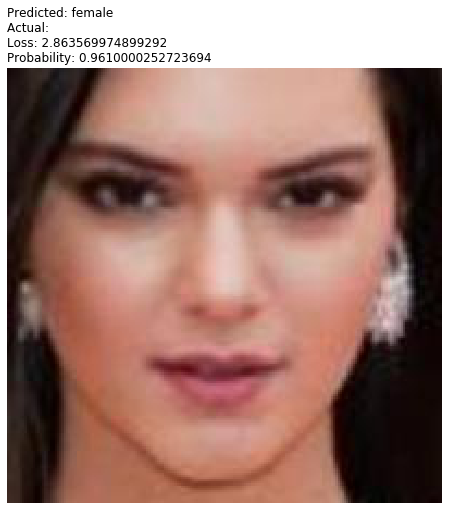

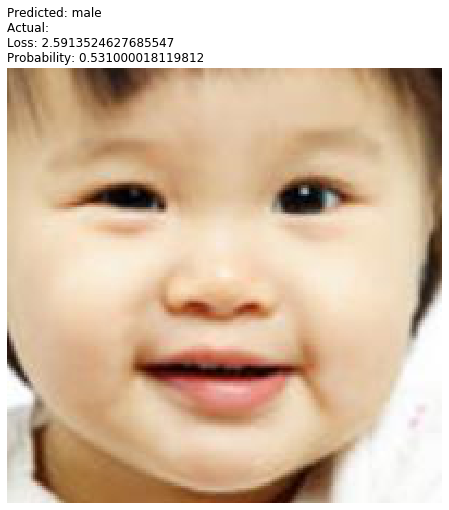

In [47]:
#did they change that API ? It was easier previously
'''
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
'''
interp = learner.interpret()
interp.top_losses()
interp.plot_multi_top_losses()

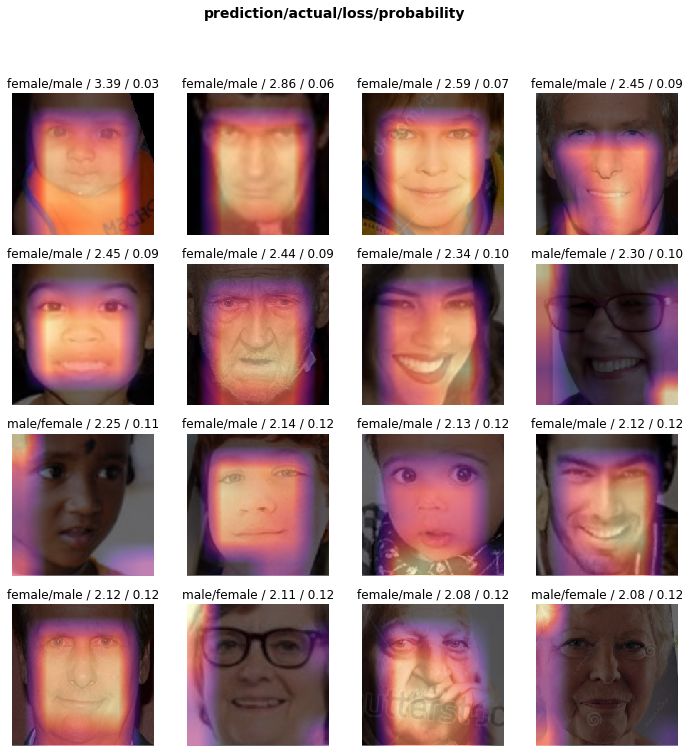

In [48]:
interp.plot_top_losses(16, heatmap=True)

In [53]:
m = LayeredModule(get_nested_layers(learner.model))


In [54]:
m

LayeredModule(
  (layers): ModuleDict(
    (0-0-conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-0): ReLU()
    (0-0-conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-1): ReLU()
    (0-0-pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (0-0-conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-2): ReLU()
    (0-0-conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-3): ReLU()
    (0-0-pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (0-0-conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-4): ReLU()
    (0-0-conv-5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-5): ReLU()
    (0-0-conv-6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0-0-relu-6): ReLU()
    

In [ ]:
tfms

In [55]:
women = learner.data.x[22].data
women.requires_grad_()
women = women.cuda()
women[None].shape


torch.Size([1, 3, 200, 200])

In [58]:
nl = NetLens(m, women[None], 0)

In [60]:
nl.generate_cam("0-0-relu-14")

RuntimeError: running_mean should contain 512 elements not 1024

In [ ]:
model = LayeredModule.from_cnn(models.alexnet(pretrained=True))

original_img, name, target_class = get_example_data(3, img_path='../old_visual/input_images/')

prep_img = preprocess_image(original_img)

prep_img.shape

nl = NetLens(model, prep_img, target_class)

cam = nl.generate_cam('features-relu-4')
cam.shape

nl.show_gradcam('features-relu-4')

## Gender with Augmentation

In [ ]:
tfms = get_transforms(max_rotate=25); 
len(tfms[0]), len(tfms)

In [ ]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_gender) \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [ ]:
l2 = cnn_learner(data, models.resnet18, metrics=[accuracy])
l2.fit_one_cycle(2,1e-3)

In [ ]:
l2.unfreeze()
l2.lr_find()
l2.recorder.plot()

In [ ]:
learner.fit_one_cycle(2,1e-3)

In [ ]:
learner.freeze_to(-2)
l2.lr_find()
l2.recorder.plot()

In [ ]:
learner.fit_one_cycle(2,1e-4)

## Ethnicity 

In [132]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_race) \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [135]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.8549677948832489, 'col_pct': 0.6055236443690699, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([ 0.0432,  0.1018, -0.0576,  0.0009]), 'invert': False}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-25, 25)}, p=0.75, resolved={'degrees': -14.307888143206544}, do_run=False, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0603569925676708, 'row_pct': 0.6924476523830565, 'col_pct': 0.7751843601093288}, do_run

In [133]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.728828,1.045931,0.634783,00:24
1,1.271385,0.897520,0.670077,00:24


In [134]:
learner.unfreeze()
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.019375,0.881037,0.690537,00:29
1,0.713650,0.582629,0.785166,00:30


In [139]:
learner.freeze_to(-2)
learner.fit_one_cycle(2,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.601086,0.540199,0.797442,00:26
1,0.554732,0.526174,0.804092,00:26


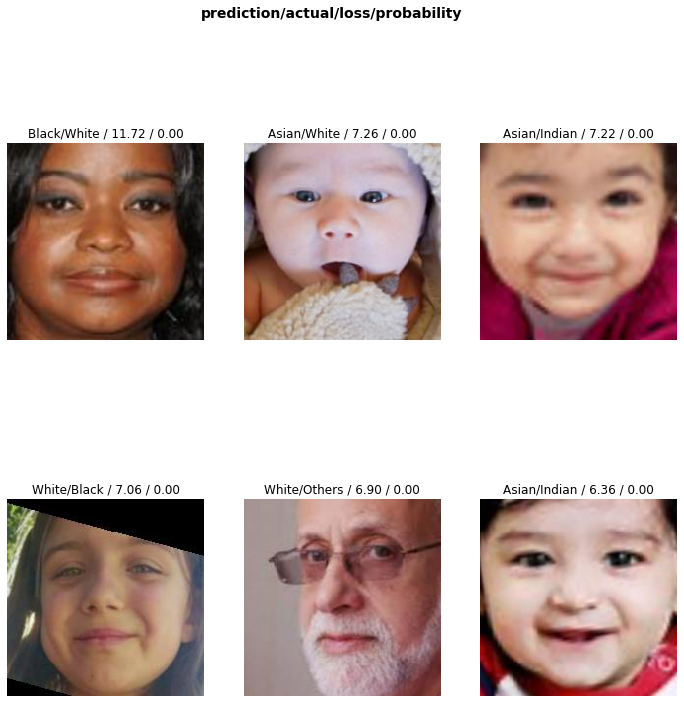

In [142]:
 learner.interpret().plot_top_losses(6)

## Regression: Age
* using MSEFlatLoss

In [172]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_age) \
            .transform(tfms)\
            .databunch() \
       )
            #.normalize() )

In [204]:
def mse_loss(input, targs):    
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return F.mse_loss(input, targs) 

In [215]:
def logger(func):
    def wrapper(*args, **kwargs):
        out = func(*args, **kwargs)
        print("logging: ", out)
        return out
    return wrapper   

In [217]:
??mean_squared_error

In [218]:
def my_mean_squared_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Mean squared error between `pred` and `targ`."
    
    pred,targ = flatten_check(pred,targ)
    out = F.mse_loss(pred, targ)
    print("fastai metrics is never working!! MSE:", out)
    return out

In [225]:
??cnn_learner

In [226]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
#not sure this works
learner.loss = my_mean_squared_error


In [227]:
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.112591,3.772084,0.156010,00:23
1,4.285512,3.596444,0.167775,00:23


In [ ]:
#FASTAI bug, where it tries to compute with 99 encoded matrix whatever
def mse_loss1(input, target): 
    #_thnn_mse_loss_forward not supported on CUDAType for Long....

    print(input.shape, target.shape, "SHAPES")
    print(target[:8])
    input = torch.argmax(input, dim=1).long().cuda()
    return F.mse_loss(input, target) 